# **1. Dataset Overview**

The dataset used in this project is sourced from the [Corn Leaf Disease dataset](https://www.kaggle.com/datasets/ndisan/corn-leaf-disease/data) available on Kaggle. It contains images of corn plant leaves categorized into different disease conditions, including healthy leaves. Each category is organized into a separate folder.

The categories included in the dataset are as follows:

- Daun Sehat: 1000 Images
- Bercak Daun: 1000 Images
- Hawar Daun: 1000 Images
- Karat Daun: 1000 Images

This dataset provides a reliable foundation for building and training deep learning models to detect and classify corn leaf diseases through image-based analysis.

# **2. Library Import**

This project uses the following libraries:

- `numpy`, `os`, `random`: Basic numerical operations, file system handling, and introducing randomness in data loading or augmentation.
- `matplotlib`: Used to visualize sample images and plot training metrics such as accuracy and loss.
- `tensorflow.keras.preprocessing.image`: For loading and preprocessing image datasets using ImageDataGenerator.
- `tensorflow.keras.applications`: Provides pretrained models like MobileNetV2 and Xception.
- `tensorflow.keras.models`, `tensorflow.keras.layers`: To build deep learning models using layers like Conv2D, Dense, Dropout, Flatten, and more.
- `regularizers`, `optimizers`, `callbacks`: Used to compile models and control training.
- `sklearn.metrics`: For confusion matrix and classification report.
- `time`: Tracks training duration in custom callbacks.

In [ ]:
# !pip install tensorflow

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, Xception
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Input
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from tensorflow.keras.preprocessing import image

# **3. Data Loading**

After mounting Google Drive and specifying the dataset path, we list all available class folders to identify the categories of corn leaf conditions. Each folder represents a unique class such as "Karat Daun", "Daun Sehat", "Bercak Daun", or "Hawar Daun".

To verify dataset integrity and understand the visual characteristics of each class, we randomly display a few sample images per category. This step ensures that the folder structure is correct and that the images are loaded successfully before proceeding with model training.

All images are resized to 224×224 pixels to match the input shape required by the deep learning models.

In [ ]:
dataset_path = "/content/drive/MyDrive/Capstone/Jagung"

class_names = os.listdir(dataset_path)
class_names = [cls for cls in class_names if os.path.isdir(os.path.join(dataset_path, cls))]
print("Daftar Kelas:", class_names)

Daftar Kelas: ['Karat Daun', 'Daun Sehat', 'Bercak Daun', 'Hawar Daun']



Label: Karat Daun


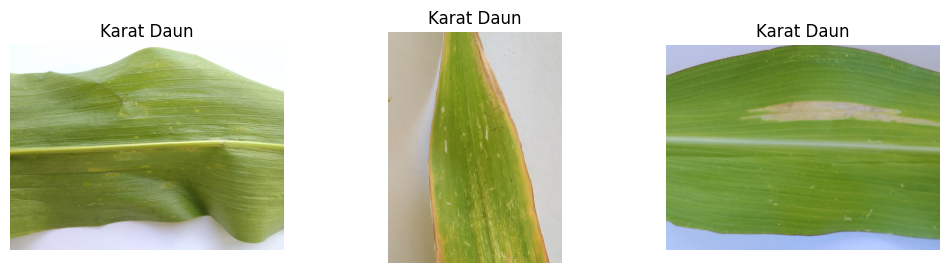


Label: Daun Sehat


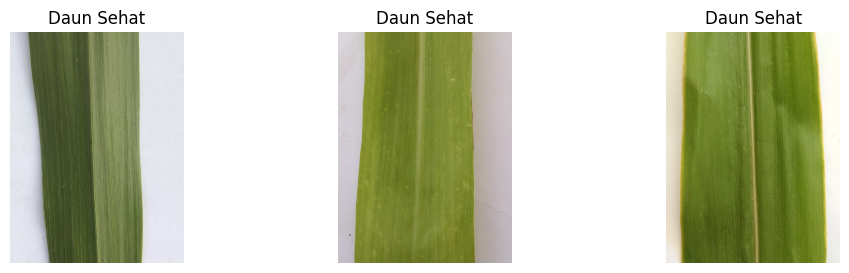


Label: Bercak Daun


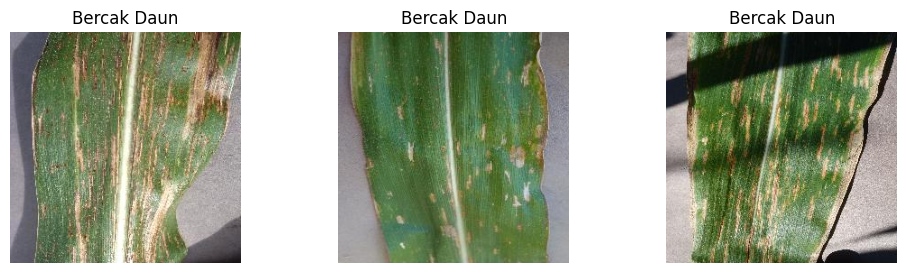


Label: Hawar Daun


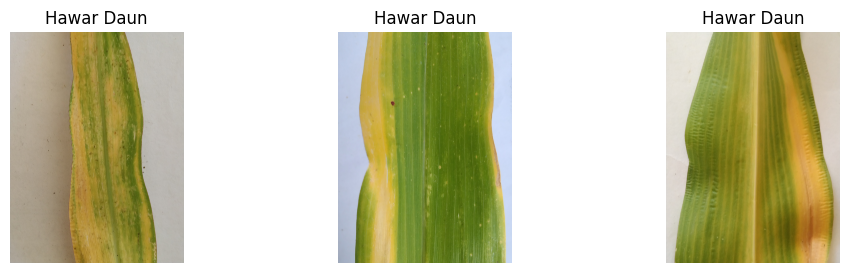

In [ ]:
n_images_per_class = 3
img_size = (224, 224)

for cls in class_names:
    folder = os.path.join(dataset_path, cls)
    images = os.listdir(folder)
    selected_images = random.sample(images, min(n_images_per_class, len(images)))

    print(f"\nLabel: {cls}")
    plt.figure(figsize=(12, 3))
    for i, img_file in enumerate(selected_images):
        img_path = os.path.join(folder, img_file)
        img = mpimg.imread(img_path)
        plt.subplot(1, n_images_per_class, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cls)
    plt.show()

# **4. Data Preprocessing**

To prepare the image dataset for model training, we use `ImageDataGenerator` for normalization and augmentation. This step ensures the model can generalize better to unseen data.

- All images are rescaled by 1./255 to normalize pixel values between 0 and 1.
- Augmentation techniques such as rotation, zoom, shift, shear, and horizontal flip are applied to the training data.
- The dataset is split into training (80%) and validation (20%) using the `validation_split` argument.
- `flow_from_directory()` automatically loads images from folders and assigns labels based on folder names.
- Each image is resized to 224×224 pixels, and data is batched in size of 32 for efficient training.

A few training images are then visualized to verify that the images are loaded correctly and the class labels are mapped as expected.

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

In [ ]:
img_size = (224, 224)
batch_size = 32

train_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    shuffle=True
)

val_data = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=True
)

Found 3200 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


In [ ]:
print("Mapping label:", train_data.class_indices)

Mapping label: {'Bercak Daun': 0, 'Daun Sehat': 1, 'Hawar Daun': 2, 'Karat Daun': 3}


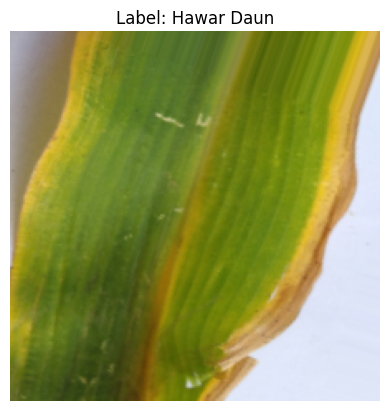

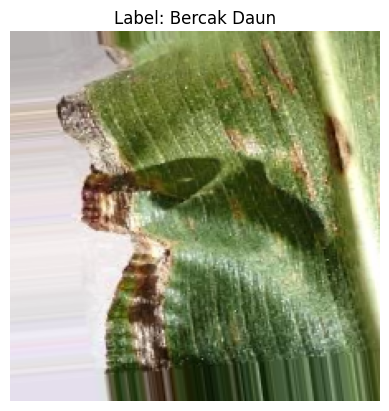

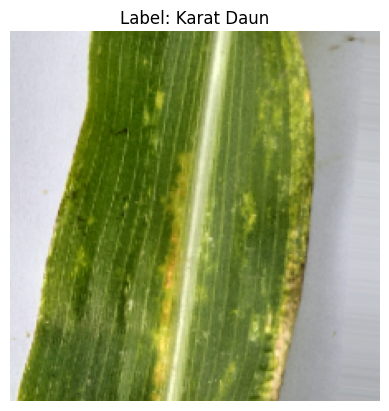

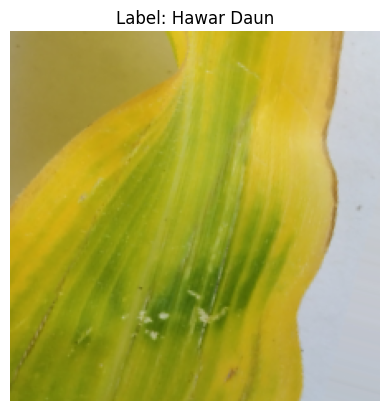

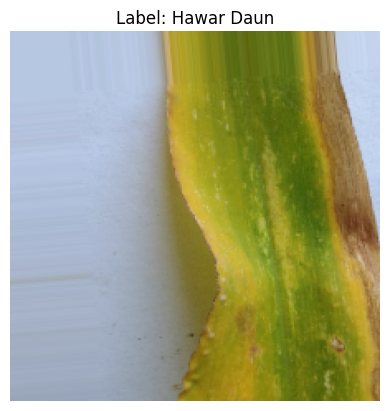

In [ ]:
images, labels = next(train_data)

for i in range(5):
    plt.imshow(images[i])
    label_index = np.argmax(labels[i])
    label_name = list(train_data.class_indices.keys())[label_index]
    plt.title(f"Label: {label_name}")
    plt.axis("off")
    plt.show()

# **5. Training and Evaluation**

## **a. CNN**

We use a custom Convolutional Neural Network (CNN) model built from scratch with three convolutional blocks. Each block consists of Conv2D, BatchNormalization, and MaxPooling2D, followed by dense layers with L2 regularization and dropout to reduce overfitting.

A classification head is added with:

- Flatten layer
- Dense layer (256 units, ReLU, L2 regularization)
- Dropout (rate = 0.5)
- Final Dense layer with softmax activation for 4 output classes

The model is compiled using:

- Optimizer: Adam (learning rate = 1e-4)
- Loss: categorical crossentropy
- Metric: accuracy

To improve training, we use:

- EarlyStopping to stop when validation accuracy stagnates
- ModelCheckpoint to save the best model based on validation accuracy
- A custom TrainingLogger callback to monitor accuracy change and training duration per epoch

The model is trained for up to 50 epochs, and training stops early once validation accuracy reaches 95% or no longer improves after 5 epochs. After training, the model is evaluated using a confusion matrix and classification report. The final CNN model achieved 83% accuracy, with strong performance on most classes, although the “Karat Daun” class showed lower recall compared to others.

In [ ]:
inputs = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=inputs, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
early_stop = EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint(
    "cnn_corn.keras",
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
class TrainingLogger(Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.prev_val_acc = None

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()
        print(f"\nEpoch {epoch + 1} dimulai...")

    def on_epoch_end(self, epoch, logs=None):
        duration = time.time() - self.epoch_start_time
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")

        if self.prev_val_acc is not None:
            delta = val_acc - self.prev_val_acc
            trend = "🔺" if delta > 0 else "🔻" if delta < 0 else "➡️"
            delta_str = f"{trend} {abs(delta)*100:.2f}%"
        else:
            delta_str = "-"

        self.prev_val_acc = val_acc

        print(f" Epoch {epoch+1} selesai dalam {duration:.2f} detik")
        print(f"  → Training Accuracy: {acc*100:.2f}%")
        print(f"  → Validation Accuracy: {val_acc*100:.2f}% ({delta_str})")

        if val_acc >= 0.95:
            print(f"\n🛑 Training dihentikan otomatis karena akurasi telah mencapai {val_acc*100:.2f}%")
            self.model.stop_training = True

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, TrainingLogger()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1 dimulai...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.7109 - loss: 2.5189  Epoch 1 selesai dalam 1325.50 detik
  → Training Accuracy: 77.88%
  → Validation Accuracy: 25.00% (-)
100/100 ━━━━━━━━━━━━━━━━━━━━ 1325s 13s/step - accuracy: 0.7116 - loss: 2.5099 - val_accuracy: 0.2500 - val_loss: 18.6973

Epoch 2 dimulai...
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8431 - loss: 1.0194 Epoch 2 selesai dalam 272.88 detik
  → Training Accuracy: 85.75%
  → Validation Accuracy: 25.12% (🔺 0.12%)
100/100 ━━━━━━━━━━━━━━━━━━━━ 273s 3s/step - accuracy: 0.8433 - loss: 1.0188 - val_accuracy: 0.2512 - val_loss: 22.5119

Epoch 3 dimulai...
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8658 - loss: 0.8523 Epoch 3 selesai dalam 276.40 detik
  → Training Accuracy: 87.37%
  → Validation Accuracy: 30.25% (🔺 5.13%)
100/100 ━━━━━━━━━━━━━━━━━━━━ 276s 3s/step - accuracy: 0.8659 - loss: 0.8522 - val_accuracy: 0.3025 - val_loss: 16.7401

Epoch 4

In [ ]:
val_data.reset()

y_true = []
y_pred = []

for i in range(len(val_data)):
    X_batch, y_batch = val_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

<Figure size 800x600 with 0 Axes>

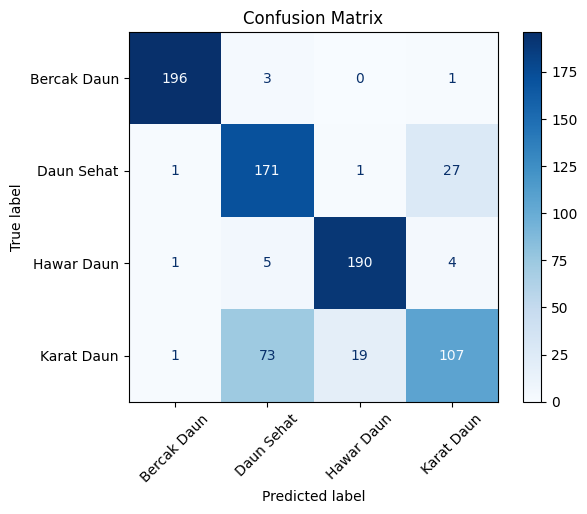

              precision    recall  f1-score   support

 Bercak Daun       0.98      0.98      0.98       200
  Daun Sehat       0.68      0.85      0.76       200
  Hawar Daun       0.90      0.95      0.93       200
  Karat Daun       0.77      0.54      0.63       200

    accuracy                           0.83       800
   macro avg       0.83      0.83      0.82       800
weighted avg       0.83      0.83      0.82       800



In [ ]:
class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

## **b. MobileNet**

We use a pretrained MobileNetV2 as the base model with `include_top=False` to remove the original classification head. The last 20 layers are set to be trainable for fine-tuning, while earlier layers remain frozen to retain learned features from ImageNet.

A custom classification head is added on top:
- GlobalAveragePooling2D layer
- Dense layer with ReLU activation and L2 regularization
- Dropout layer to prevent overfitting
- Final Dense layer with softmax for 9 output classes

The model is compiled using:
- Optimizer: Adam (learning rate = 1e-4)
- Loss: categorical crossentropy
- Metric: accuracy

To improve training, we use:
- `EarlyStopping` to stop when validation accuracy stagnates
- `ModelCheckpoint` to save the best model based on validation accuracy
- A custom `TrainingLogger` callback to show per-epoch accuracy change and training time

The model is trained for up to 50 epochs, and training stops early once validation accuracy reaches 95% or no longer improves for 5 epochs.

After training, the model is evaluated using a confusion matrix and classification report. The final model achieved **87% accuracy**, with high precision and recall across all 4 corn leaf disease classes.

In [ ]:
base_model = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[:-20]:
    layer.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
predictions = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
checkpoint = ModelCheckpoint(
    "mobilenetv2_corn.keras",
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, TrainingLogger()]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1 dimulai...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7093 - loss: 1.1391 Epoch 1 selesai dalam 275.10 detik
  → Training Accuracy: 83.97%
  → Validation Accuracy: 53.75% (-)
100/100 ━━━━━━━━━━━━━━━━━━━━ 275s 3s/step - accuracy: 0.7106 - loss: 1.1362 - val_accuracy: 0.5375 - val_loss: 1.9522

Epoch 2 dimulai...
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9338 - loss: 0.6019 Epoch 2 selesai dalam 271.37 detik
  → Training Accuracy: 93.31%
  → Validation Accuracy: 60.75% (🔺 7.00%)
100/100 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.9338 - loss: 0.6019 - val_accuracy: 0.6075 - val_loss: 1.9805

Epoch 3 dimulai...
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9439 - loss: 0.5766 Epoch 3 selesai dalam 269.72 detik
  → Training Accuracy: 94.56%
  → Validation Accuracy: 69.00% (🔺 8.25%)
100/100 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.9439 - loss: 0.5765 - val_accuracy: 0.6900 - val_loss: 1.5833

Epoch 4 dimulai

In [ ]:
val_data.reset()

y_true = []
y_pred = []

for i in range(len(val_data)):
    X_batch, y_batch = val_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

<Figure size 800x600 with 0 Axes>

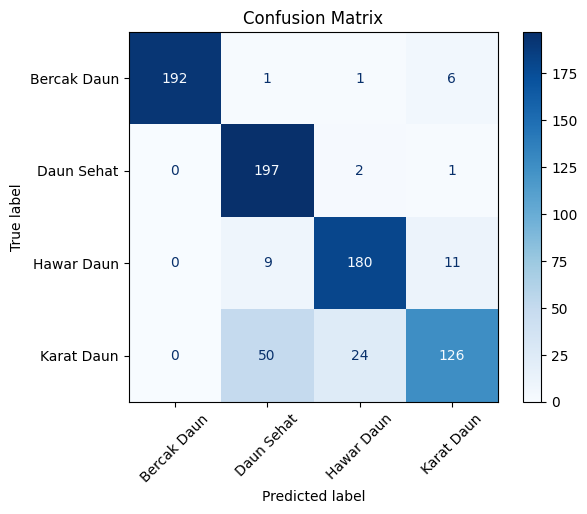

              precision    recall  f1-score   support

 Bercak Daun       1.00      0.96      0.98       200
  Daun Sehat       0.77      0.98      0.86       200
  Hawar Daun       0.87      0.90      0.88       200
  Karat Daun       0.88      0.63      0.73       200

    accuracy                           0.87       800
   macro avg       0.88      0.87      0.86       800
weighted avg       0.88      0.87      0.86       800



In [ ]:
class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

## **b. Xception**

We also experimented with the Xception model as an alternative to MobileNetV2. Xception is a deeper architecture that uses depthwise separable convolutions and is known for its strong performance on image classification tasks.

The model was fine-tuned on the corn leaf disease dataset, following the same training strategy:
- The top layers were customized with a GlobalAveragePooling2D layer, followed by a Dense layer with ReLU activation, dropout, and a softmax output layer.
- The model was compiled with the Adam optimizer, categorical crossentropy loss, and accuracy as the evaluation metric.
- Early stopping and model checkpoint callbacks were applied to monitor validation accuracy and prevent overfitting.

After training, the model achieved **90% validation accuracy**. The evaluation results show strong performance across most classes, with precision and recall scores above 80% for nearly all categories.

The confusion matrix and classification report confirm that Xception performs slightly better than MobileNetV2 on this dataset.

In [ ]:
base_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights="imagenet"
)

for layer in base_model.layers[:-20]:
    layer.trainable = False

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
checkpoint = ModelCheckpoint(
    "xception_corn.keras",
    monitor="val_accuracy",
    save_best_only=True
)

In [ ]:
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stop, checkpoint, TrainingLogger()]
)


Epoch 1 dimulai...
Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7063 - loss: 1.5871 Epoch 1 selesai dalam 307.66 detik
  → Training Accuracy: 83.41%
  → Validation Accuracy: 88.38% (-)
100/100 ━━━━━━━━━━━━━━━━━━━━ 308s 3s/step - accuracy: 0.7076 - loss: 1.5839 - val_accuracy: 0.8838 - val_loss: 1.0938

Epoch 2 dimulai...
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9420 - loss: 0.9387 Epoch 2 selesai dalam 267.03 detik
  → Training Accuracy: 94.19%
  → Validation Accuracy: 84.75% (🔻 3.62%)
100/100 ━━━━━━━━━━━━━━━━━━━━ 267s 3s/step - accuracy: 0.9420 - loss: 0.9385 - val_accuracy: 0.8475 - val_loss: 1.1965

Epoch 3 dimulai...
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9565 - loss: 0.8661 Epoch 3 selesai dalam 263.90 detik
  → Training Accuracy: 95.81%
  → Validation Accuracy: 90.13% (🔺 5.37%)
100/100 ━━━━━━━━━━━━━━━━━━━━ 264s 3s/step - accuracy: 0.9565 - loss: 0.8658 - val_accuracy: 0.9013 - val_loss: 0.9608

Epoch 4 dimulai

In [ ]:
val_data.reset()

y_true = []
y_pred = []

for i in range(len(val_data)):
    X_batch, y_batch = val_data[i]
    y_true.extend(np.argmax(y_batch, axis=1))
    preds = model.predict(X_batch, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

<Figure size 800x600 with 0 Axes>

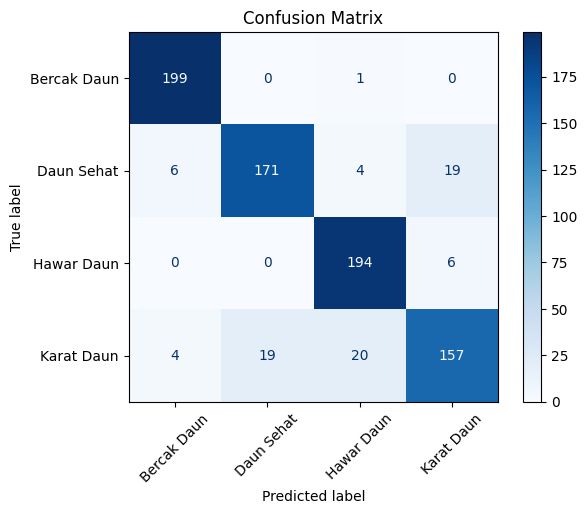

              precision    recall  f1-score   support

 Bercak Daun       0.95      0.99      0.97       200
  Daun Sehat       0.90      0.85      0.88       200
  Hawar Daun       0.89      0.97      0.93       200
  Karat Daun       0.86      0.79      0.82       200

    accuracy                           0.90       800
   macro avg       0.90      0.90      0.90       800
weighted avg       0.90      0.90      0.90       800



In [ ]:
class_names = list(val_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

# **6. Inference**

After training and saving the best model (e.g., `xception_corn.keras`), we perform inference on a new unseen image to predict the type of corn leaf disease.

The steps include:
- Loading the trained model using `load_model()`.
- Loading a test image from the dataset using `image.load_img()`, resizing it to 224×224 pixels.
- Preprocessing the image: converting it to an array, normalizing pixel values, and expanding dimensions to match the model input shape.
- Using `model.predict()` to get the probability distribution over the 4 classes.
- Sorting and displaying the **top-3 most probable predictions** with their confidence scores.

This step demonstrates how the model can be used in real-world scenarios to identify corn leaf diseases based on image input.

In [ ]:
model = load_model("xception_corn.keras")

img_path = "/content/drive/MyDrive/Capstone/Jagung/Bercak Daun/Corn_Gray_Spot (100).JPG"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

class_names = list(train_data.class_indices.keys())

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Jagung:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Top-3 Prediksi Penyakit Padi:
- Bercak Daun: 100%
- Karat Daun: 0%
- Daun Sehat: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Jagung/Daun Sehat/IMG_20230610_063629.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Jagung:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
Top-3 Prediksi Penyakit Padi:
- Daun Sehat: 100%
- Karat Daun: 0%
- Hawar Daun: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Jagung/Hawar Daun/IMG_20230610_061847.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Jagung:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Top-3 Prediksi Penyakit Padi:
- Hawar Daun: 100%
- Karat Daun: 0%
- Daun Sehat: 0%


In [ ]:
img_path = "/content/drive/MyDrive/Capstone/Jagung/Karat Daun/IMG_20230411_060628.jpg"
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

preds = model.predict(img_array)[0]

top_3 = sorted(zip(class_names, preds), key=lambda x: x[1], reverse=True)[:3]

print("Top-3 Prediksi Penyakit Jagung:")
for label, prob in top_3:
    print(f"- {label}: {prob*100:.0f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Top-3 Prediksi Penyakit Padi:
- Karat Daun: 98%
- Hawar Daun: 1%
- Daun Sehat: 0%
